In [24]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
os.chdir('/Users/tsukasamiyaji/Desktop/Python3')
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori as ap, association_rules as ap_rl
from icecream import ic
from joblib import Parallel,delayed
import shap

# Data Preparation

In [28]:
df = pd.read_csv('Fingerhut_modified.csv')
df = df.drop(['Unnamed: 0'],axis=1) 
pivot_table = pd.pivot_table(df, values='count', index='account_id', columns='ed_id',aggfunc='sum').fillna(0)
export_piv2 = pd.DataFrame(pivot_table)
export_piv2 = export_piv2.reset_index()
export_piv2.columns = ['account_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','26','27','28','29']
export_piv2.set_index('account_id',inplace=True)
export_piv2.head()


,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,26,27,28,29
account_id,,,,,,,,,,,,,,,,,,,,,
-2147477843,4.0,1.0,0.0,9.0,5.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
-2147476504,3.0,1.0,1.0,18.0,8.0,7.0,1.0,1.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
-2147476077,0.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2147475397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
-2147473858,2.0,0.0,2.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,...,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
cond1 = export_piv2['7'] > 0
cond2 = export_piv2['18'] > 0
cond3 = export_piv2['29'] > 0 

condition_act  = [cond3, ~cond3]
choices_act    = [0,1]

condition_pur  = [(cond1 | cond2), (~cond1 | ~cond2)]
choices_pur     = [0,1]


export_piv2["condition_purchase"] = np.select(condition_pur, choices_pur, default=np.nan)
export_piv2["condition_activation"] = np.select(condition_act, choices_act, default=np.nan)
export_piv2

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,26,27,28,29,condition_purchase,condition_activation
account_id,,,,,,,,,,,,,,,,,,,,,
-2147477843,4.0,1.0,0.0,9.0,5.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
-2147476504,3.0,1.0,1.0,18.0,8.0,7.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
-2147476077,0.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
-2147475397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
-2147473858,2.0,0.0,2.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147469625,0.0,2.0,2.0,15.0,11.0,5.0,1.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2147475185,5.0,1.0,0.0,5.0,3.0,3.0,2.0,2.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2147476319,7.0,1.0,4.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


- In the data preparation phase, a pivot table is constructed where each cell represents the frequency of specific events for each customer account ID. For example, if a customer browses the website 20 times, this is recorded under event ID No.4 with a frequency of 20. Additionally, customers are categorized based on whether they made a purchase and whether they activated their account. A purchase is indicated by a customer undertaking event No.7 (placing an order on the website) or event No.18 (placing an order by phone). Account activation is indicated by event No.29 (account activation). These customer actions are then encoded in the pivot table, with '0' signifying an action taken (purchase made/account activated) and '1' indicating the opposite (no purchase made/account not activated), creating a comprehensive matrix that combines the frequency of event occurrences with the binary classifications of purchase and activation status.

# XGBoost (Purchase)

In [30]:
ids_to_remove = ['7','18','28']
export_piv2_1 = export_piv2.drop(columns=ids_to_remove)


- Before applying XGBoost for classification, it's crucial to eliminate certain events that directly indicate a purchase, to ensure the model does not use these as direct predictors of purchasing behavior. Specifically, event IDs No.7 and No.18, which denote product purchases via the website and by phone, respectively, are removed to prevent the model from relying on these clear indicators. Similarly, event No.28, related to order shipment, is also excluded because it inherently signifies that a purchase has occurred. By omitting these event IDs, the objective is to assess the impact of other, seemingly unrelated events on the likelihood of making a purchase, thereby focusing on more subtle indicators of customer behavior. 

In [31]:
# Modify the dependent variable as per your requirements
X, y = export_piv2_1.drop(['condition_purchase', 'condition_activation'], axis=1), export_piv2_1[['condition_purchase']]

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

# Construct dmatrix for train model
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Train a model, modify the objective method as per your requirements
xgb_classifier = xgb.XGBClassifier(n_estimators=100, objective='binary:hinge', tree_method='hist', eta=0.1, max_depth=10, enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

# make predictions for test data
y_pred = xgb_classifier.predict(X_test)
xgb_prediction = [round(value) for value in y_pred]

# Print accuracy rate
print(f"Accuracy rate: {sum(xgb_prediction == y_test['condition_purchase'])/len(xgb_prediction)}")

# Sample numeric vector from classification model
numeric_vector = xgb_prediction

# Count the occurrences of each element
element_counts = Counter(numeric_vector)

# Print the result
print("Number of Each Element:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

# Sample numeric vector from actual test data
numeric_vector = y_test['condition_purchase']

# Count the occurrences of each element
element_counts = Counter(numeric_vector)

# Print the result
print("Number of Each Element:")
for element, count in element_counts.items():
    print(f"{element}: {count}")


Accuracy rate: 0.9712487371263718
Number of Each Element:
1: 414464
0: 106174
Number of Each Element:
1.0: 405353
0.0: 115285


- After removing specific event IDs that directly affect classification, we trained the XGBoost model using the training data, which was split into 70% for training and 30% for testing, randomly. In the XGBoost model, we set the objective as `binary:hinge` because the output is binary, and this setting is used when probabilities, rather than just class labels, are desired. Additionally, this objective achieved the highest accuracy rate. Our accuracy rate for the binary classification using 30% test data, determining whether customers purchase products or not, is 0.971, indicating a very high accuracy level. We also observed the number in each classification group, where 1 indicates non-purchase, and 0 indicates purchase. However, since XGBoost is a supervised learning algorithm for classification problems, it does not inherently identify influential features within the data. Therefore, we introduced SHapley Additive exPlanations (SHAP) values, conceived by Lloyd Shapley. SHAP values offer an extensive framework for interpreting machine learning models by quantifying each feature's contribution to individual predictions, thus significantly enhancing model transparency. They ensure fair attribution of the prediction output among all features, providing insightful observations both locally and globally about model behavior. Their consistent nature guarantees that a feature's contribution is accurately reflected, irrespective of model changes. Furthermore, SHAP values are model-agnostic, applicable across a diverse range of machine learning techniques from deep learning to tree-based and linear models, making them a versatile tool for understanding and elucidating model predictions. In contrast, traditional feature importance methods, widely used in complex machine learning contexts such as XGBoost and other ensemble techniques, often fall short. They typically fail to provide detailed insights at the individual prediction level, overlook feature interactions, and can be misleading due to sensitivity to correlated or high cardinality features. These methods also struggle with inconsistency, model specificity, capturing non-linear relationships, and a lack of standardization across different model types. In this scenario, SHAP values prove to be more reliable and accurate than traditional feature importance metrics in XGBoost packages, offering a deeper insight into our XGBoost model and identifying which events most significantly affect purchasing decisions.

In [6]:
# Use SHAP to explain the output of the model
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_test)


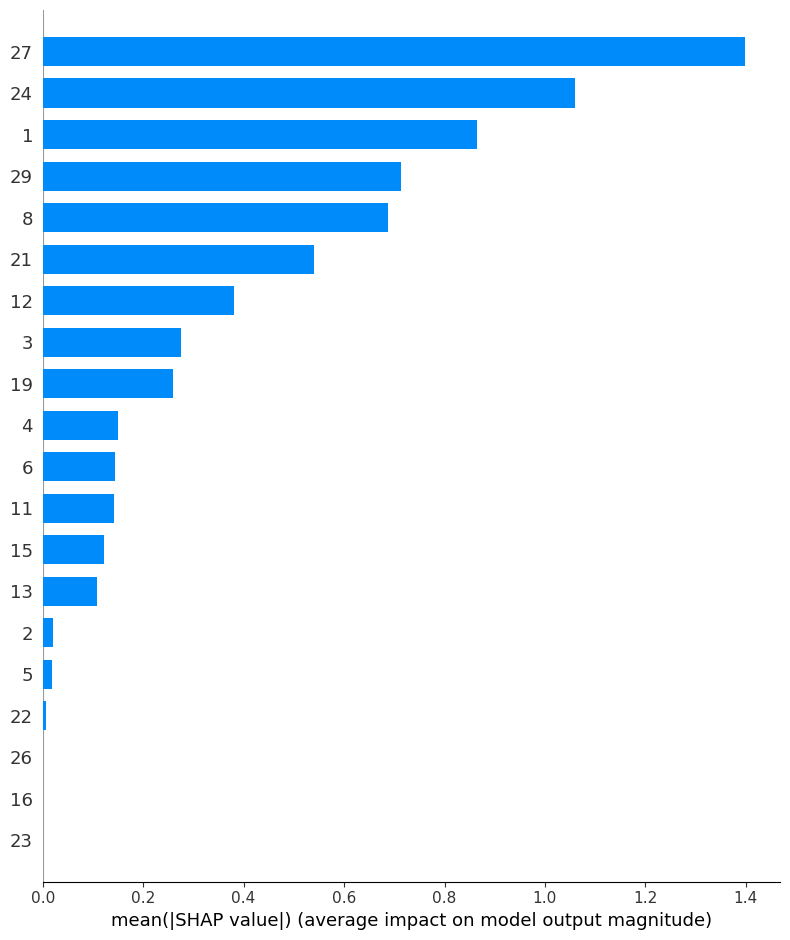

In [7]:
# Summary plot of feature importance using SHAP
shap.summary_plot(shap_values, X_test.values, plot_type="bar", feature_names = X_test.columns)


- Here is the feature importance derived from SHAP values. Higher values indicate a greater impact on our classification. The graph reveals that events No.27, No.24, No.1, No.29, and No.8 significantly influence classification. No.27, representing the clearance of downpayments made by customers, is crucial for determining purchase decisions, which makes sense logically. Similarly, No.24, indicating a click on a campaign email, plays a vital role in the purchasing decision. Event No.1, the creation of a promotion, suggests that providing promotion code can influence purchases. No.29, related to account activation, is another significant event, underscoring its importance in the purchasing process. Additionally, No.8, which involves placing a downpayment, is highlighted as influential. While No.21, sending a catalog email to customers, is crucial, it does not contribute as significantly as the others. Campaign and catalog emails evidently wield substantial influence over purchasing decisions. Account activation and distribution of promotion codes also significantly impact purchasing. The downpayment event is noteworthy as well. However, while this plot clarifies which events influence purchasing decisions, it does not indicate whether their impact is positive or negative on the classification of purchasing. To discern the direction of these influences (positive or negative), further analysis with additional plots is necessary.

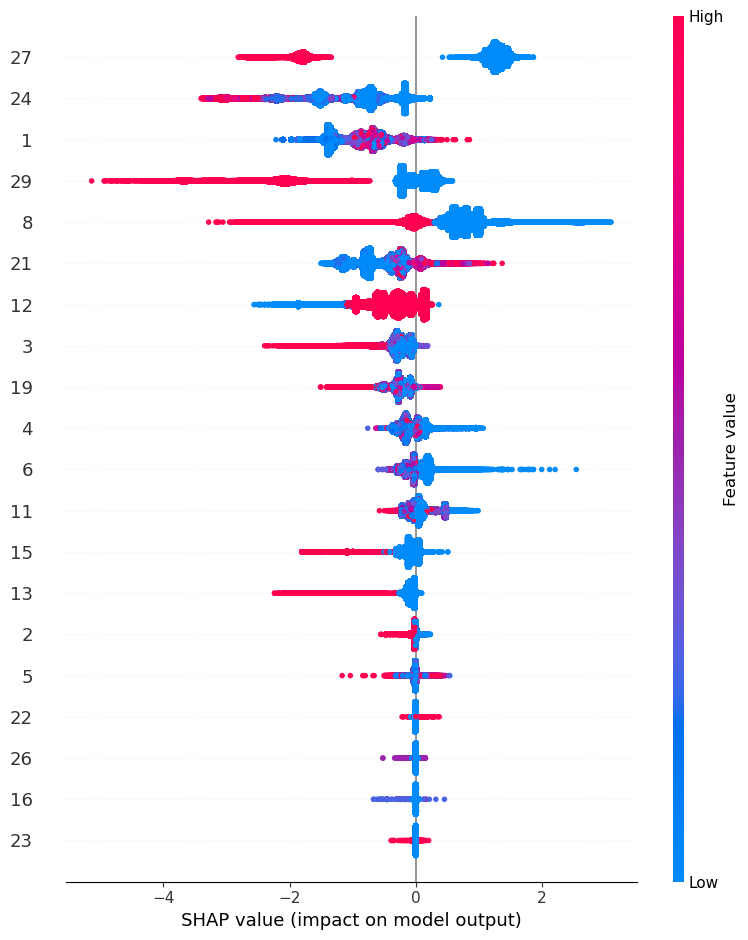

In [8]:
shap.summary_plot(shap_values, X_test.values, feature_names = X_test.columns)


- The SHAP summary plot above illustrates the impact of different events on our binary classification model. The feature value here represents the frequency of each event for individual customers, essentially tracking how often each event occurs for them. For example, a red dot on the horizontal line for event 27 indicates customers with a high frequency of this event, which correlates with a negative SHAP value. This suggests that customers with more frequent interaction in event 27, which is related to clearing downpayments, are more likely to make a further purchase (classified as 0). Conversely, a blue dot signifies customers with a low frequency of the event. When red dots are observed on the left side of the plot, it implies that a higher occurrence of the event is associated with an increased likelihood of purchasing. If red dots appear on the right side, it indicates the opposite: a higher occurrence corresponds with a decreased likelihood of purchase. Event 1, which involves sending promotion codes, presents a mixed picture; a limited number of promotions sent to a customer could lead to a purchase, but an excess may lose its effectiveness, possibly due to the perceived availability of discounts at any time, diminishing the urgency to buy. Event 24, involving customers clicking on campaign emails, clearly shows that those who engage more with campaign emails are more likely to purchase products than those who click on few or no campaign emails. Similarly, event 29, account activation, indicates that customers who activate their accounts are more inclined to purchase, with no significant impact observed for non-purchases. Event 8, related to placing downpayments, suggests that more frequent downpayments are indicative of a willingness to purchase, although it's not a definitive predictor since some high-frequency downpayments align with a SHAP value of 0, indicating no association with the outcome. Lastly, event 21, receiving catalog emails, seems to suggest that receiving an excessive number of catalog emails might dissuade purchases, while a moderate amount could encourage them, potentially due to over-saturation leading to annoyance.

# XGBoost (Activate)

In [32]:
ids_to_remove = ['12','15','29'] 
export_piv2_2 = export_piv2.drop(columns=ids_to_remove)

- In this analysis, we turn our attention to account activation, a step that occurs after purchasing but before the placement and clearance of downpayments, according to another set of data. Events 12, 15, and 29 have a direct association with account activation. To delve deeper into how other, less directly related events influence account activation, we have removed these particular events from our dataset. This allows us to explore the effects of other customer interactions on the likelihood of activating an account.

In [33]:
# Modify the dependent variable as per your requirements
X, y = export_piv2_2.drop(['condition_purchase', 'condition_activation'], axis=1), export_piv2_2[['condition_activation']]

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

# Construct dmatrix for train model
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Train a model, modify the objective method as per your requirements
xgb_classifier = xgb.XGBClassifier(n_estimators=100, objective='binary:hinge', tree_method='hist', eta=0.1, max_depth=10, enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

# make predictions for test data
y_pred = xgb_classifier.predict(X_test)
xgb_prediction = [round(value) for value in y_pred]

# Accuracy rate, modify the dependent variable as per your requirements
print(f"Accuracy rate: {sum(xgb_prediction == y_test['condition_activation'])/len(xgb_prediction)}")

# Sample numeric vector
numeric_vector = xgb_prediction

# Count the occurrences of each element
element_counts = Counter(numeric_vector)

# Print the result
print("Number of Each Element:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

# Sample numeric vector, modify the objective method as per your requirements
numeric_vector = y_test['condition_activation']

# Count the occurrences of each element
element_counts = Counter(numeric_vector)

# Print the result
print("Number of Each Element:")
for element, count in element_counts.items():
    print(f"{element}: {count}")


Accuracy rate: 0.9695028023309862
Number of Each Element:
1: 410017
0: 110621
Number of Each Element:
1.0: 395667
0.0: 124971


In [34]:
# Use SHAP to explain the output of the model
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_test)


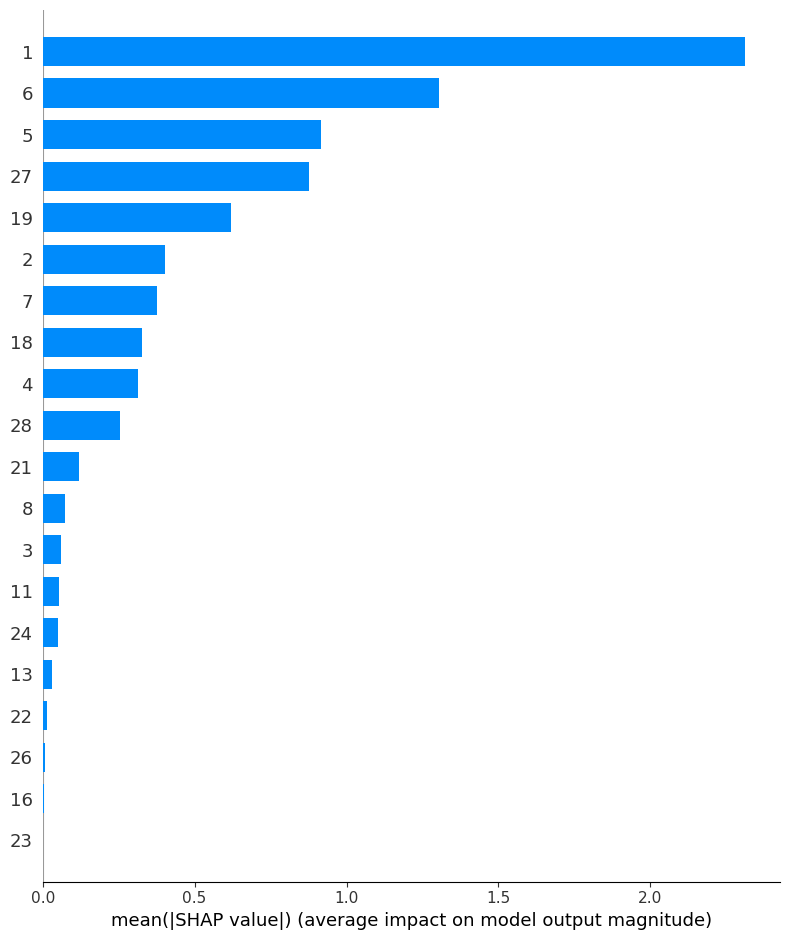

In [35]:
# Summary plot of feature importance using SHAP
shap.summary_plot(shap_values, X_test.values, plot_type="bar", feature_names = X_test.columns)


- This analysis identifies that event No.1, the creation of a promotion, has the most significant impact on classifying accounts as activated or not activated. Additionally, events No.6 and No.5, which correspond to beginning checkout and viewing the cart on the website, respectively, also play crucial roles in predicting account activation. Events No.27 and No.19, related to downpayment clearance and application views on the web, are influential as well. However, to discern whether these events impact account activation positively or negatively, a mere bar plot is insufficient. Therefore, we must refer to the SHAP summary plot presented below, which provides deeper insight into the directionality of each event's influence on the classification outcome.

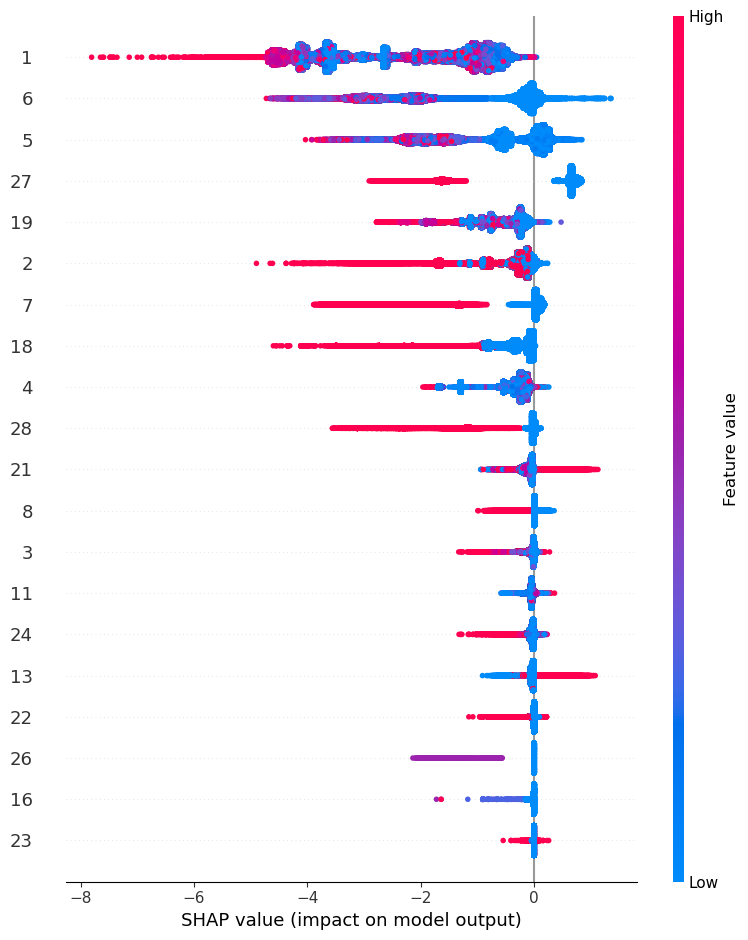

In [36]:
shap.summary_plot(shap_values, X_test.values, feature_names = X_test.columns)
